In [1]:
import sys; sys.path.insert(0, "..")
from src.models import NeuralNet
from src.utils import generate_data

In [2]:
from autograd import numpy as np
from autograd import grad
from autograd.misc.optimizers import adam
from autograd import scipy as sp
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
class BayesianNN(NeuralNet):
    """Implement a feed-forward Bayesian neural network with HMC sampler.
    Inherited from NeuralNet class so we can perform optimization to obtain MLE/MAP solution for weights,
    and use them as initial position for HMS sampling"""
    
    def sample_HMC(self, x_train, y_train, prior_sd = 5., noise_sd = 3., HMC_param = None):
        self.prior_sd = prior_sd
        self.noise_sd = noise_sd
        
        if HMC_param is None:
            self.HMC_param = {'step_size':1e-3, 
                              'leapfrog_steps':50, 
                              'total_samples':5000, 
                              'burn_in':.1, 
                              'thinning_factor':2}
            
        else: self.HMC_param = HMC_param
            
        # unpack HMC parameters
        step_size = self.HMC_param['step_size']
        leapfrog_steps = self.HMC_param['leapfrog_steps']
        total_samples = self.HMC_param['total_samples']
        burn_in = self.HMC_param['burn_in']
        thinning_factor = self.HMC_param['thinning_factor']
        
        # prepare parameters for prior distribution
        D = self.D
        N = y_train.shape[1]
        sigma_y = noise_sd**2
        Sigma_W = prior_sd**2 * np.eye(D)
        Sigma_W_inv = prior_sd**(-2) * np.eye(D)
        log_Sigma_W_det = D * np.log(prior_sd**2) # re-formalize after taking log to maintain numerical stability

        # define log prior 
        def log_prior(W):
            constant = -0.5 * (D * np.log(2 * np.pi) + log_Sigma_W_det)
            exponential = -0.5 * np.diag(np.dot(np.dot(W, Sigma_W_inv), W.T))
            return constant + exponential

        # define log likelihood
        def log_likelihood(W):
            constant = N * (- 0.5 * np.log(2 * np.pi) - np.log(sigma_y))
            exponential = -0.5 * sigma_y**-2 * np.sum((y_train.reshape((1, 1, N)) - self.forward(W, x_train))**2, axis=2).flatten()
            return constant + exponential

        # define the log joint density
        neg_log_density = lambda w: -log_likelihood(w) - log_prior(w)  

        # define potential energy and gradient
        U = neg_log_density
        u_grad = grad(U)
        
        # define kinetic energy and gradient
        K = lambda p: 0.5*(np.dot(p,p)) + np.log(np.linalg.norm(np.eye(D)))/2 + D*np.log(2*np.pi)/2
        k_grad = grad(K)

        # initialization
        samples = np.zeros((total_samples,D))
        q_curr = self.weights  # initial position
        n_acc = 0

        # HMC sampling with leapfrog integrator
        for i in range(total_samples):
            if i%100 == 0:
                print('Iteration {}, accept = {}'.format(i,n_acc/(i+1e-10)))
            p_curr = np.random.multivariate_normal(mean = np.zeros(D), cov = np.eye(D))
            p_t, q_t = p_curr, q_curr
            for _ in range(leapfrog_steps):
                p_half = p_t - (step_size/2)*u_grad(q_t).reshape((-1,))
                q_t = q_t + step_size*k_grad(p_half).reshape((1,-1))
                p_t = p_half - (step_size/2)*u_grad(q_t).reshape((-1,))
            p_T, q_T = -p_t, q_t
            alpha = np.min([1,np.exp(U(q_curr) + K(p_curr) - U(q_T) - K(p_T))])
            if np.random.uniform() <= alpha:
                q_curr = q_T
                n_acc += 1
            samples[i,:] = q_curr.reshape((-1,))
            
        # store HMC results
        self.accept = n_acc/total_samples
        self.samples = samples
        self.thinned_trace = samples[int(burn_in*total_samples)::thinning_factor,:]
        
    def get_posterior_predictive(self, x_test):
        y_test = self.forward(self.thinned_trace, x_test)[:,0,:]
        y_test += np.random.normal(0, self.noise_sd, size=y_test.shape)
        return y_test

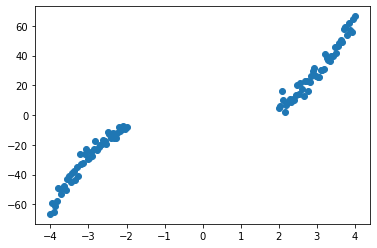

In [4]:
# Generate synthetic data
x, y, x_test = generate_data(number_of_points=50, noise_variance=9)

plt.scatter(x, y)
plt.show()

In [5]:
# Set up architecture for Bayesia neural network

activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

width = [50, 20] # Use architecture used in paper
hidden_layers = len(width)
input_dim = 1
output_dim = 1

architecture = {
    'width': width,
    'hidden_layers': hidden_layers,
    'input_dim': input_dim,
    'output_dim': output_dim,
    'activation_fn_type': 'relu',
    'activation_fn_params': 'rate=1',
    'activation_fn': activation_fn,
}

params = {
    'step_size': 5e-2,
    'max_iteration': 3000,
    'random_restarts': 1,
}

reg_param = 1e-5

random = np.random.RandomState(207) #set random state to make the experiments replicable

# Initialize a Bayesian neural network
bnn = BayesianNN(architecture, random=random)

#fit Bayesian neural network to obtain MLE/MAP solution for weights
x_train = x.reshape((1, -1))
y_train = y.reshape((1, -1))
x_test = x_test.reshape((1, -1))

bnn.fit(x_train, y_train, params, reg_param=reg_param)

Iteration 0 lower bound 8957.88026725112; gradient mag: 15177.983170600566
Iteration 100 lower bound 13.225948530370275; gradient mag: 10.501365556409716
Iteration 200 lower bound 10.201768155083856; gradient mag: 11.613892763269538
Iteration 300 lower bound 10.246686399907302; gradient mag: 42.11707839678081
Iteration 400 lower bound 10.585690723671798; gradient mag: 90.89784946633752
Iteration 500 lower bound 10.09147658002785; gradient mag: 5.921144090176589
Iteration 600 lower bound 10.183111387974028; gradient mag: 47.20345652195835
Iteration 700 lower bound 10.639641194470078; gradient mag: 110.05293621479885
Iteration 800 lower bound 10.919592849899365; gradient mag: 122.01721562479479
Iteration 900 lower bound 10.0491194048444; gradient mag: 30.85314394649624
Iteration 1000 lower bound 10.715777364599981; gradient mag: 107.74787806852856
Iteration 1100 lower bound 10.42585557098024; gradient mag: 92.50725611745891
Iteration 1200 lower bound 10.394354257225118; gradient mag: 85.

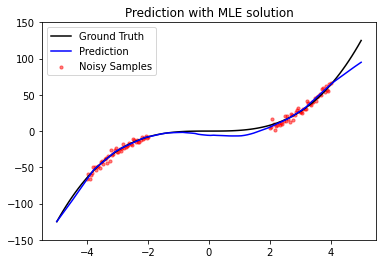

In [6]:
# visualize prediction on test data with MLE/MAP weights
y_test_pred = bnn.forward(bnn.weights, x_test)

plt.scatter(x,y, color='red', s = 10, alpha = 0.5, label="Noisy Samples")
plt.plot(x_test.flatten(), x_test.flatten()**3, color='black', label="Ground Truth")
plt.plot(x_test.flatten(), y_test_pred.flatten(), color='blue', label="Prediction")
plt.ylim([-150, 150])
plt.title("Prediction with MLE solution")
plt.legend()
plt.show()

In [7]:
# Set up HMC parameters and perform sampling
HMC_param = {'step_size': 2e-3, 
             'leapfrog_steps': 50, 
             'total_samples': 5000, 
             'burn_in': 0.1, 
             'thinning_factor': 2}

bnn.sample_HMC(x_train, y_train, prior_sd = 5., noise_sd = 3., HMC_param = HMC_param)

print('Final accept =', bnn.accept)

Iteration 0, accept = 0.0


/Users/shihyitseng/anaconda3/envs/am207/lib/python3.7/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


Iteration 100, accept = 0.98999999999901
Iteration 200, accept = 0.9949999999995026
Iteration 300, accept = 0.98999999999967
Iteration 400, accept = 0.9849999999997537
Iteration 500, accept = 0.9819999999998036
Iteration 600, accept = 0.9799999999998366
Iteration 700, accept = 0.9771428571427175
Iteration 800, accept = 0.9774999999998778
Iteration 900, accept = 0.9744444444443361
Iteration 1000, accept = 0.9679999999999032
Iteration 1100, accept = 0.9618181818180943
Iteration 1200, accept = 0.9549999999999204
Iteration 1300, accept = 0.9499999999999269
Iteration 1400, accept = 0.9464285714285038
Iteration 1500, accept = 0.9426666666666038
Iteration 1600, accept = 0.9374999999999414
Iteration 1700, accept = 0.9305882352940629
Iteration 1800, accept = 0.9238888888888376
Iteration 1900, accept = 0.913157894736794
Iteration 2000, accept = 0.9069999999999546
Iteration 2100, accept = 0.8947619047618621
Iteration 2200, accept = 0.8809090909090509
Iteration 2300, accept = 0.8752173913043098
It

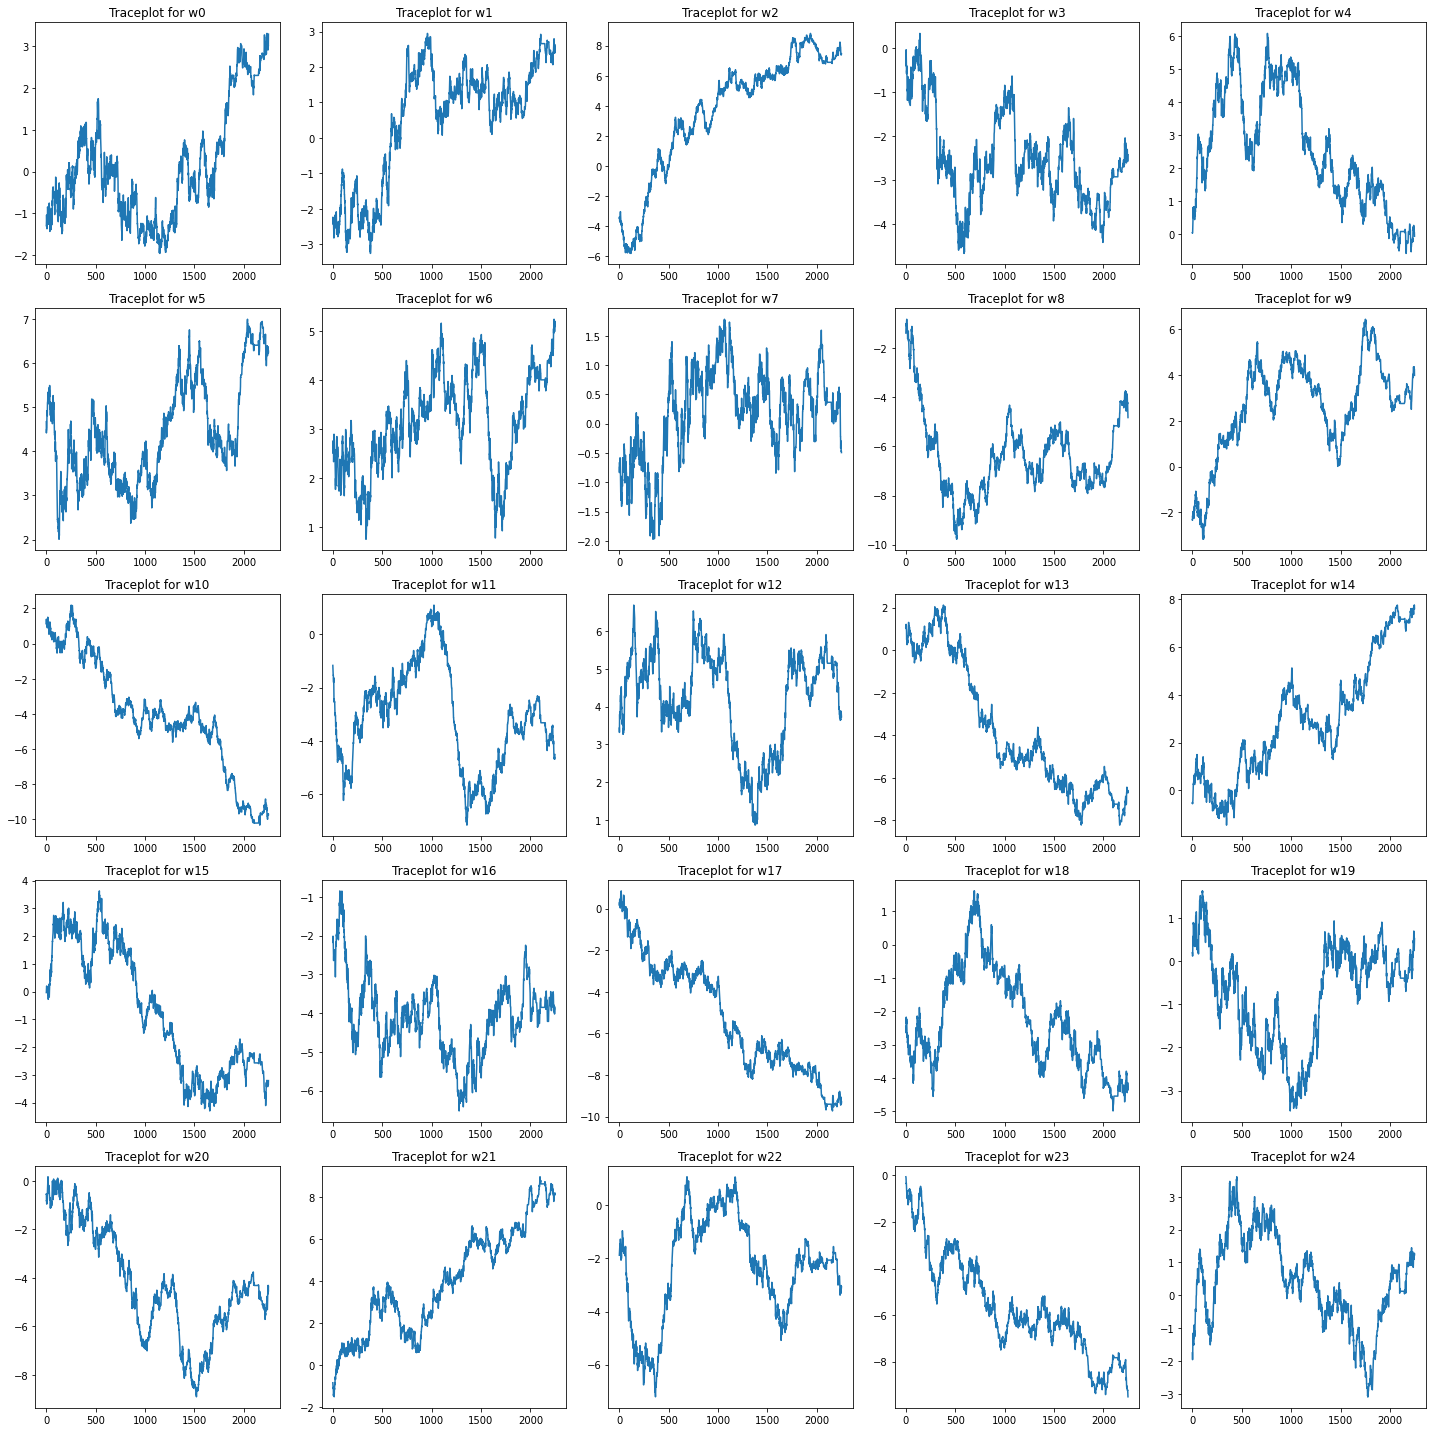

In [8]:
# Visualize some traceplots for diagnostics
fig, ax = plt.subplots(5,5,figsize = (20,20))
for i in range(25):
    ax[i//5,i%5].plot(bnn.thinned_trace[:,i])
    ax[i//5,i%5].set_title('Traceplot for w{}'.format(i))
plt.tight_layout()

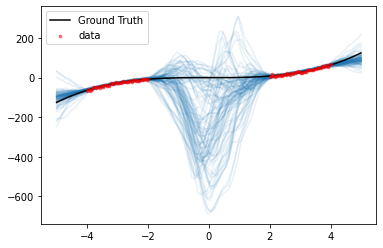

In [9]:
# Visualize posterior predictive
posterior_predictive = bnn.get_posterior_predictive(x_test)

plt.plot(x_test.T, posterior_predictive[np.random.choice(posterior_predictive.shape[0], size = 100, replace = False),:].T,color='tab:blue', alpha=0.1)
plt.scatter(x_train.flatten(), y_train.flatten(), s=7, color='r', alpha=0.5,label='data',zorder = 1000)
plt.plot(x_test.flatten(), x_test.flatten()**3, color='black', label="Ground Truth")
plt.legend(loc='best')
plt.show()